In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from collections import Counter

In [53]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df = pd.concat([df_train.assign(ind="train"), df_test.assign(ind="test")])

In [3]:
print(f"Número total de features: {df.drop(columns=['Id', 'SalePrice']).shape[1]}")

Número total de features: 80


C:\Users\vinic\AppData\Local\Temp\ipykernel_6824\3792898354.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.get("SalePrice"), kde=False)


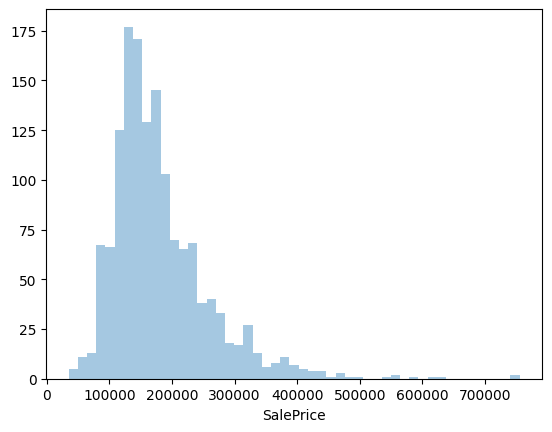

In [41]:
# distribuição dos valores na variável target
sns.distplot(df.get("SalePrice"), kde=False)
plt.show()

# Data Analysis

In [4]:
# # encontrando os outliers das variáveis numéricas

# numerical_df = df.select_dtypes(exclude=['object'])

# for column in numerical_df:
#     plt.figure(figsize=(16, 4))
#     sns.set_theme(style="whitegrid")
#     sns.boxplot(numerical_df[column])

Temos muitos outliers, e remover todos ou simplesmente imputar com algum outro valor, pode prejudicar significativamente nossa análise, portanto optamos por trabalhar com modelos que sejam robustos a outlies

## Check Missing Values

In [5]:
missing_value_cols = df.isnull().sum()
missing_value_cols[missing_value_cols > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

# Feature Engineering

## Feature division

In [6]:
numerical_features = df.drop(columns=['Id', 'OverallQual', 'OverallCond']).select_dtypes(exclude='object').columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [7]:
#Get a list of all the categorical features that have the keyword 'Qual' OR 'Cond' OR 'Qu' OR 'QC' in the feature name
feature_rating_Qual = [col for col in df.columns if 'Qual' in col and df[col].dtypes=='object']
feature_rating_Cond = [col for col in df.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df[col].dtypes=='object']
feature_rating_Qu = [col for col in df.columns if 'Qu' in col and df[col].dtypes=='object' and col not in feature_rating_Qual]
feature_rating_QC = [col for col in df.columns if 'QC' in col and df[col].dtypes=='object']

cat_feature_with_rating = feature_rating_Qual + feature_rating_Cond + feature_rating_Qu + feature_rating_QC
cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
ordinal_cat_features = cat_feature_with_rating + cat_feature_with_legit_na + ['OverallQual', 'OverallCond']

In [8]:
categorical_cols=[cname for cname in df.columns if df[cname].dtypes=='object' and cname!='ind']
remaining_cat_cols = [cname for cname in categorical_cols if cname not in ordinal_cat_features]

In [9]:
print(f"Número total de features: {df.drop(columns=['Id', 'SalePrice']).shape[1]}")
print(f"Features numéricas: {len(numerical_features)}")
print(f"Features categóricas não ordinais: {len(remaining_cat_cols)}")
print(f"Features categóricas ordinais: {len(ordinal_cat_features)}")

Número total de features: 80
Features numéricas: 35
Features categóricas não ordinais: 25
Features categóricas ordinais: 20


## Handling Missing Values

In [10]:
df[ordinal_cat_features] = df[ordinal_cat_features].fillna('Missing')

Although the columns above may seen to have an ordinal behaviour, we don't know initially the impact of them in the price of houses to assume they are ordinal features. For example, we cannot assume that a paved alley house is more expensive than a gravel alley one, without prior analysis

In [11]:
# Filing Other Categorical Features with Mode
categorical_features = [cname for cname in remaining_cat_cols]
for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

In [12]:
# Filling Numerical Features with Median
for col in numerical_features:
    df[col] = df[col].fillna(df[col].mean())

## Handling High Cardinality Featues

Increasing the number of different values in a feature simply increases the total number of possible combinations that can be made using the input row (containing n such features). Say we have two features with two distinct values each, this gives us a total of 4 possible ways to combine the two features. Now if one of these had three distinct values we would have 3X2 =6 possible ways to combine them.

In classical non-parametric learning algorithms (e.g. nearest-neighbor, Gaussian kernel SVM, Gaussian kernel Gaussian Process, etc.) the model needs to see at least one example for each of these combinations (or at least as many as necessary to cover all the variations of configurations of interest), in order to produce a correct answer, one that is different from the target value required for other nearby configurations.

In most cases, high cardinality makes it difficult for the model to identify such patterns and hence the model doesn’t generalise well to examples outside the training set.

Link of Article: https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b

In [13]:
# Handling high cardinality features - Depending on the performance of the model, we can decide to drop these features
high_cardinality_features = [cname for cname in df.columns if df[cname].dtypes == 'object' and df[cname].nunique() >= 10]
high_cardinality_features

# Choose a threshold
# Sort unique values in the column by their frequency in descending order
# Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.
# These are the unique categories we will keep and instances of all other categories shall be replaced by “other”.
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column
  
#Transform the high cardinality features
for feature in high_cardinality_features:
  df[feature],_ = cumulatively_categorise(df[feature])

#Check the unique values in the transformed high cardinality features
for feature in high_cardinality_features:
  print(f'{feature}: {df[feature].unique()}')

Neighborhood: ['CollgCr' 'Other' 'Mitchel' 'Somerst' 'NWAmes' 'OldTown' 'BrkSide'
 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'Edwards' 'Gilbert']
Exterior1st: ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'Other']
Exterior2nd: ['VinylSd' 'MetalSd' 'Other' 'HdBoard' 'Wd Sdng']


## Handling Date Features

Temos 5 Features com dados em formatos de Data: 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'
Utilizando como base a solução apresentada no artigo [Top 3% rank🥇: 🏠Kaggle House Prices — Advanced Regression Techniques Using Bagging Ensemble](https://parisrohan.medium.com/top-3-rank-kaggle-house-prices-advanced-regression-techniques-using-bagging-ensemble-ff2a3f9b70cb) vimos que as features de ano de construção, ano de construção da garagem, ano e mês de venda, por exemplo, não trazem muita informação sobre que possa justificar o preço de uma casa.

Assim, trabalhar em cima delas para extrair a "idade" da casa, ou garagem, por exemplo, é melhor

Além idsso, o ano e mês de venda, sem nenhum outro contexto, como tendências macroeconômicas, ciclos de mercado entre outras informações, não parecem fazer muito sentido para prever o preço da casa, portanto decidimos seguir o exemplo e também remover essas colunas

In [14]:
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
df.drop(["YrSold", "MoSold", "GarageYrBlt", "YearRemodAdd", "YearBuilt"], axis=1, inplace=True)

## Tratando features relacionadas à área da casa, cômodos, etc.

A variável TotalBsmtSF contém informações da área do porão tipo 1, área do porão tipo 2 e a área inacabada. Achamos melhor segregar a área inacabada de modo a evitar que uma área total considerando uma área inacabada e, portanto, dando a impressão de uma casa maior, possa ter impacto no preço

Da mesma forma concatenamos os valores de área dos dois andares em um apenas, para considerar a área total

In [15]:
df["TotalFinishedBsmtSF"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]
df.drop(["BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF"], axis=1, inplace=True)
df["TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
df.drop(["1stFlrSF",  "2ndFlrSF"], axis=1, inplace=True)

Concatenamos o número total de banheiros em uma variável apenas

In [16]:
df["TotalBath"] = (
    df["BsmtFullBath"]
    + df["BsmtHalfBath"]  * 0.5
    + df["FullBath"]
    + df["HalfBath"] * 0.5
)

df.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], axis=1, inplace=True)

In [17]:
numerical_features = df.drop(columns=['Id', 'SalePrice', 'OverallQual', 'OverallCond']).select_dtypes(exclude='object').columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'GarageAge', 'HouseAge', 'RemodelAge', 'TotalFinishedBsmtSF',
       'TotalFlrSF', 'TotalBath'],
      dtype='object')

## Tratando viés das features numéricas

Com base no artigo [Techniques to handle skewed data for Machine Learning [with examples]](https://roshinie-jayasundara.medium.com/techniques-to-handle-skewed-data-for-machine-learning-with-examples-5ab61069640b#:~:text=Techniques%20to%20handle%20skewed%20data%20for%20Machine%20Learning,Square%20Root%20Transformation%20...%207%20Box-Cox%20Transformation%20), vimos que dados enviesados podem levar a decisões enviesadas, na medida que o modelo é treinado em um conjunto desproporcional de dados. No nosso caso, por exemplo, se um modelo é treinado majoritariamente com dados de casas de alto preço, ele pode ter uma performance ruim, para prever o preço de casas mais baratas.

Dessa forma, vamos identificar as features com um fator de viés maior que 0.5 e, dessa forma, aplicar uma transformação logarítmica

In [18]:
skew_df = pd.DataFrame(numerical_features, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df


,Feature,Skew,Absolute Skew,Skewed
0,MSSubClass,1.375457,1.375457,True
1,LotFrontage,1.645574,1.645574,True
2,LotArea,12.822431,12.822431,True
3,MasVnrArea,2.611549,2.611549,True
4,BsmtUnfSF,0.919508,0.919508,True
5,LowQualFinSF,12.088761,12.088761,True
6,GrLivArea,1.269358,1.269358,True
7,BedroomAbvGr,0.326324,0.326324,False
8,KitchenAbvGr,4.302254,4.302254,True
9,TotRmsAbvGrd,0.758367,0.758367,True


In [19]:
#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df[column] = np.log1p(df[column])

c:\Users\vinic\Documents\GitHub\kaggle-competitions\house-prices-advanced-regression-techniques\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Encoding Ordinal Categorical Features

In [20]:
ordinal_cat_features

['ExterQual',
 'BsmtQual',
 'KitchenQual',
 'GarageQual',
 'ExterCond',
 'BsmtCond',
 'GarageCond',
 'FireplaceQu',
 'HeatingQC',
 'PoolQC',
 'Alley',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageType',
 'GarageFinish',
 'Fence',
 'MiscFeature',
 'OverallQual',
 'OverallCond']

In [21]:
# features that that are in ordinal_cat_features but is not in ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC

diff_list = list(set(ordinal_cat_features) - set(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'OverallQual', 'OverallCond']))
diff_list

['MiscFeature', 'Fence', 'GarageFinish', 'GarageType', 'Alley']

Features da diff_list serão codificadas pelo one hot encode, pois não apresentam uma relação clara de ordenação entre seus dados

In [22]:
features_to_ordinal_encode = list(set(ordinal_cat_features) - set(diff_list))

#sort to alphabetical order
features_to_ordinal_encode.sort()

In [23]:
features_to_ordinal_encode

['BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'ExterCond',
 'ExterQual',
 'FireplaceQu',
 'GarageCond',
 'GarageQual',
 'HeatingQC',
 'KitchenQual',
 'OverallCond',
 'OverallQual',
 'PoolQC']

In [24]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
categories = [
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # BsmtCond
    ['Missing', 'No', 'Mn', 'Av', 'Gd'], # BsmtExposure
    ['Missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType1
    ['Missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType2
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # BsmtQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'], # ExterCond
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'], # ExterQual
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # FireplaceQu
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # GarageCond
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # GarageQual
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # HeatingQC
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # KitchenQual
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # OverallCond
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # OverallQual
    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # PoolQC
]
enc.set_params(encoded_missing_value=-1, dtype=int, categories=categories)
enc.set_output(transform='pandas')
df[features_to_ordinal_encode] = enc.fit_transform(df[features_to_ordinal_encode])
df[features_to_ordinal_encode].head()

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,HeatingQC,KitchenQual,OverallCond,OverallQual,PoolQC
0,3,1,6,1,4,2,3,0,3,3,5,4,4,6,0
1,3,4,5,1,4,2,2,3,3,3,5,3,7,5,0
2,3,2,6,1,4,2,3,3,3,3,5,4,4,6,0
3,4,1,5,1,3,2,2,4,3,3,4,4,4,6,0
4,3,3,6,1,4,2,3,3,3,3,5,4,4,7,0


## Encoding Non Ordinal Categorical Features

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

ohe = OneHotEncoder(feature_name_combiner='concat', dtype=int, sparse=False)
lbe = LabelEncoder()

# categorical_features = categorical_features + diff_list
categorical_features = diff_list + categorical_features

ohe_output = ohe.fit_transform(df[categorical_features].drop(['Street', 'CentralAir'], axis=1))
number_of_encoded_features = ohe_output.shape[1]
lbe_output_street  = lbe.fit_transform(df['Street'])
lbe_output_central_air  = lbe.fit_transform(df['CentralAir'])
df['Street'] = lbe_output_street
df['CentralAir'] = lbe_output_central_air
df_encoded = pd.DataFrame(ohe_output, columns=ohe.get_feature_names_out(), index=df.index)
# df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_encoded], axis=1)
df.drop(categorical_features, axis=1, inplace=True)


c:\Users\vinic\Documents\GitHub\kaggle-competitions\house-prices-advanced-regression-techniques\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
df.shape

(2919, 203)

In [27]:
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,4.189655,9.042040,6,4,5.283204,3,2,4,...,0,0,0,1,0,0,0,0,1,0
1,2,3.044522,4.394449,9.169623,5,7,0.000000,2,2,4,...,0,0,0,1,0,0,0,0,1,0
2,3,4.110874,4.234107,9.328212,6,4,5.093750,3,2,4,...,0,0,0,1,0,0,0,0,1,0
3,4,4.262680,4.110874,9.164401,6,4,0.000000,2,2,3,...,0,0,0,1,1,0,0,0,0,0
4,5,4.110874,4.442651,9.565284,7,4,5.860786,3,2,4,...,0,0,0,1,0,0,0,0,1,0


In [28]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'GarageAge', 'HouseAge', 'RemodelAge', 'TotalFinishedBsmtSF',
       'TotalFlrSF', 'TotalBath'],
      dtype='object')

## Standardazing numerical cols 

In [29]:
from sklearn.preprocessing import StandardScaler

# Drop 'Id' from numerical_features
numerical_features = [col for col in numerical_features if col != 'Id']

# Replace infinities with NaN
df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.nan)

# Now scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_features].dropna())
scaled_df = pd.DataFrame(scaled_data, columns=numerical_features)
df[numerical_features] = scaled_df
df[numerical_features]

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,GarageAge,HouseAge,RemodelAge,TotalFinishedBsmtSF,TotalFlrSF,TotalBath
0,0.419053,-0.049045,-0.102853,1.208506,-0.326652,-0.116953,0.567376,0.169571,-0.200549,1.020291,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.991735,-0.950687,-0.887503,0.734132,0.576655,1.585978
1,-1.121278,0.589377,0.147730,-0.806167,0.013700,-0.116953,-0.369940,0.169571,-0.200549,-0.197602,...,-0.112794,-0.309202,-0.066713,-0.188578,0.052365,0.319887,0.357308,0.841295,-0.360029,0.348767
2,0.419053,0.089528,0.459215,1.136261,0.240272,-0.116953,0.701557,0.169571,-0.200549,-0.197602,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.911419,-0.732332,-0.839625,0.611408,0.710746,1.585978
3,0.638335,-0.294634,0.137475,-0.806167,0.357118,-0.116953,0.579981,0.169571,-0.200549,0.449503,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.871262,1.121448,0.596695,0.345273,0.589252,-0.269838
4,0.419053,0.739641,0.924845,1.428759,0.305158,-0.116953,1.342096,1.385319,-0.200549,1.530877,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.871262,-0.642933,-0.743871,0.709483,1.350852,1.585978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-1.121278,-0.194065,-0.337068,-0.806167,0.574701,-0.116953,-0.471830,-1.046177,-0.200549,-0.197602,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.991735,-0.950687,-0.935380,0.555548,-0.461849,0.967373
1455,0.419053,-0.194065,-0.230806,-0.806167,0.661054,-0.116953,0.451548,0.169571,-0.200549,0.449503,...,-0.112794,-0.309202,-0.066713,-0.188578,-0.871262,-0.642933,-0.791748,-1.425921,0.460905,0.348767
1456,-1.121278,0.776102,0.769424,1.019474,0.403575,-0.116953,1.161406,0.169571,-0.200549,0.449503,...,-0.112794,-0.309202,-0.066713,-0.188578,0.092522,0.343243,-0.073588,0.832778,1.170285,0.967373
1457,0.638335,-0.002166,0.030128,-0.806167,0.616573,-0.116953,1.535295,1.385319,-0.200549,1.530877,...,-0.112794,-0.309202,-0.066713,6.184925,1.578356,0.914014,-0.935380,0.424453,1.543921,-0.269838


In [30]:
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.419053,-0.049045,-0.102853,6,4,1.208506,3,2,4,...,0,0,0,1,0,0,0,0,1,0
1,2,-1.121278,0.589377,0.147730,5,7,-0.806167,2,2,4,...,0,0,0,1,0,0,0,0,1,0
2,3,0.419053,0.089528,0.459215,6,4,1.136261,3,2,4,...,0,0,0,1,0,0,0,0,1,0
3,4,0.638335,-0.294634,0.137475,6,4,-0.806167,2,2,3,...,0,0,0,1,1,0,0,0,0,0
4,5,0.419053,0.739641,0.924845,7,4,1.428759,3,2,4,...,0,0,0,1,0,0,0,0,1,0


# Modelling

In [31]:
test, train= df[df["ind"].eq("test")], df[df["ind"].eq("train")]
test.drop(["SalePrice", "ind"], axis=1, inplace=True)

train.drop(["ind"], axis=1, inplace=True)

log_target = np.log(train['SalePrice'])

train.drop(["SalePrice"], axis=1, inplace=True)

C:\Users\vinic\AppData\Local\Temp\ipykernel_6824\651531548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["SalePrice", "ind"], axis=1, inplace=True)
C:\Users\vinic\AppData\Local\Temp\ipykernel_6824\651531548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["ind"], axis=1, inplace=True)
C:\Users\vinic\AppData\Local\Temp\ipykernel_6824\651531548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop

In [32]:
catboost_params = {
    'iterations': 5000,
    'learning_rate': 0.02,
    'depth': 4,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 20
}

xgboost_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'min_child_weight': 2,
}

models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "xgb": XGBRegressor(**xgboost_params, verbose=0)
}

In [33]:
results = {}
kf = KFold(n_splits=10)
for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

KeyboardInterrupt: 

In [ ]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1249279304182762
0.021127726674718537
----------
xgb
1.1272016195234515
0.01923903851166692


In [35]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import numpy as np

# Definindo os parâmetros a serem pesquisados para cada modelo
catboost_grid = {
    'iterations': [1000, 2000, 5000],
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [3, 4, 6]
}


# Inicializando os modelos
catboost_model = CatBoostRegressor(eval_metric='RMSE', early_stopping_rounds=20, verbose=0)

# Definindo o KFold
kf = KFold(n_splits=10)

# Definindo o grid search para CatBoost
catboost_grid_search = GridSearchCV(
    estimator=catboost_model, 
    param_grid=catboost_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf,
    verbose=1,
    n_jobs=-1
)


# Executando o grid search para CatBoost
catboost_grid_search.fit(train, log_target)
best_catboost_model = catboost_grid_search.best_estimator_
best_catboost_params = catboost_grid_search.best_params_
best_catboost_score = np.exp(np.sqrt(-catboost_grid_search.best_score_))


results = {
    "best_catboost_model": best_catboost_model,
    "best_catboost_params": best_catboost_params,
    "best_catboost_score": best_catboost_score
}

print("Best CatBoost Model:", best_catboost_model)
print("Best CatBoost Params:", best_catboost_params)
print("Best CatBoost Score:", best_catboost_score)


Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best CatBoost Model: <catboost.core.CatBoostRegressor object at 0x0000010BFA6477C0>
Best CatBoost Params: {'depth': 6, 'iterations': 5000, 'learning_rate': 0.02}
Best CatBoost Score: 1.1249910365287876


In [36]:
model = best_catboost_model

model.fit(train, log_target)

predictions = model.predict(test)

predictions = np.exp(predictions)

# save predicionts in csv
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)

C:\Users\vinic\AppData\Local\Temp\ipykernel_6824\2156377532.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sub.get("SalePrice"), kde=False)


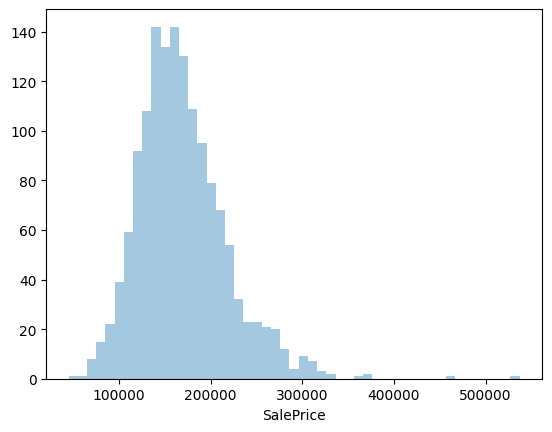

In [39]:
df_sub = pd.read_csv('./submission.csv')
# distribuição dos valores na variável target
sns.distplot(df_sub.get("SalePrice"), kde=False)
plt.show()

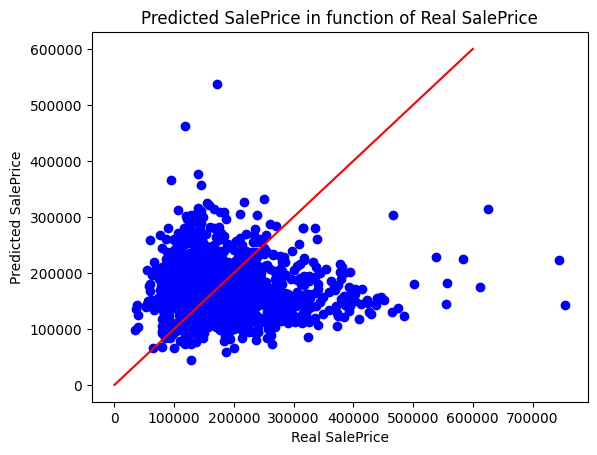

In [58]:
y_test = df[df["ind"].eq("train")].get("SalePrice")
y_test = y_test.drop([0])
y_pred = df_sub["SalePrice"].values.tolist()
plt.plot(y_test, y_pred, 'bo')
plt.plot([0, 600000], [0, 600000], 'r-')
plt.ylabel('Predicted SalePrice')
plt.xlabel('Real SalePrice')
plt.title('Predicted SalePrice in function of Real SalePrice')
plt.show()